In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ENGLISH TO BENGALI

In [2]:
import pathlib
import string
import re
import io
import os
from string import digits
from numpy import array,argmax,random,take
import pickle as pkl
from pickle import dump
from pickle import load
from numpy.random import rand
from numpy.random import shuffle
from unicodedata import normalize
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense, LSTM, Embedding, RepeatVector, Input, Concatenate, TimeDistributed, Bidirectional, TextVectorization
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
%matplotlib inline
import seaborn as sns
from nltk.translate.bleu_score import corpus_bleu
sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', 200)

In [3]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import warnings
warnings.filterwarnings('ignore')

In [6]:
# text_file ="/content/drive/MyDrive/NLP_Data/ben.txt"
text_file = "/content/drive/MyDrive/NMT_6TH_SEM/ben.txt"

In [7]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, ben = line.split("\t")[:2]
    ben = "[start] " + ben + " [end]"
    text_pairs.append((eng, ben))
  
print(text_pairs[1])

('Go.', '[start] যান। [end]')


In [8]:
for i in range(5):
    print(text_pairs[i])

('Go.', '[start] যাও। [end]')
('Go.', '[start] যান। [end]')
('Go.', '[start] যা। [end]')
('Run!', '[start] পালাও! [end]')
('Run!', '[start] পালান! [end]')


In [9]:
random.shuffle(text_pairs)
train_pairs = text_pairs[:2000]
val_pairs = text_pairs[2000 : 2500]
test_pairs = text_pairs[2500 : 3000]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

4617 total pairs
2000 training pairs
500 validation pairs
500 test pairs


In [10]:
import pickle

In [11]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NLP_Data/eng_vector/input_eng.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT_6TH_SEM/input_eng.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_eng = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_eng = TextVectorization.from_config(pickle_obj_eng["config"])
vector_eng.set_vocabulary(pickle_obj_eng["vocabulary"])
vector_eng.set_weights(pickle_obj_eng["weights"])

# NOW "vector" can be used in same way

In [12]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT_6TH_SEM/output_ben.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_ben = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_ben = TextVectorization.from_config(pickle_obj_ben["config"])
vector_ben.set_vocabulary(pickle_obj_ben["vocabulary"])
vector_ben.set_weights(pickle_obj_ben["weights"])

# NOW "vector" can be used in same way

In [13]:
def format_dataset(eng, ben):
    eng = vector_eng(eng)
    ben = vector_ben(ben)
    return ({"encoder_inputs": eng, "decoder_inputs": ben[:, :-1],}, ben[:, 1:])

vocab_size = 100000
sequence_length = 20
batch_size = 128

def make_dataset(pairs):
    eng_texts, ben_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    ben_texts = list(ben_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, ben_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [14]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 20)
inputs["decoder_inputs"].shape: (128, 20)
targets.shape: (128, 20)


In [15]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'latent_dim': self.latent_dim,
            'num_heads': self.num_heads,
        })
        return config

In [16]:
embed_dim = 256
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [19]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   25605120    ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   2630144     ['positional_embedding[

In [20]:
epochs = 100  # This should be at least 30 for convergence

transformer.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/100
16/16 [==============================] - 10s 459ms/step - loss: 0.0511 - accuracy: 0.9515 - val_loss: 1.2599 - val_accuracy: 0.5669
Epoch 2/100
16/16 [==============================] - 7s 419ms/step - loss: 0.0421 - accuracy: 0.9556 - val_loss: 1.2695 - val_accuracy: 0.5725
Epoch 3/100
16/16 [==============================] - 7s 419ms/step - loss: 0.0336 - accuracy: 0.9615 - val_loss: 1.2717 - val_accuracy: 0.5744
Epoch 4/100
16/16 [==============================] - 7s 419ms/step - loss: 0.0315 - accuracy: 0.9620 - val_loss: 1.2880 - val_accuracy: 0.5688
Epoch 5/100
16/16 [==============================] - 7s 419ms/step - loss: 0.0315 - accuracy: 0.9619 - val_loss: 1.2930 - val_accuracy: 0.5716
Epoch 6/100
16/16 [==============================] - 7s 420ms/step - loss: 0.0281 - accuracy: 0.9643 - val_loss: 1.3122 - val_accuracy: 0.5710
Epoch 7/100
16/16 [==============================] - 7s 419ms/step - loss: 0.0283 - accuracy: 0.9639 - val_loss: 1.3201 - val_accuracy: 0.575

In [22]:
transformer.save('/content/drive/MyDrive/NMT_6TH_SEM/eng-ben.h5')

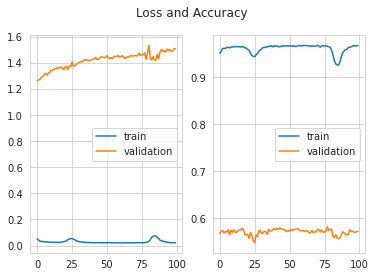

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss and Accuracy')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train','validation'])
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train','validation'])

In [24]:
ben_vocab = vector_ben.get_vocabulary()
ben_index_lookup = dict(zip(range(len(ben_vocab)), ben_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = vector_eng([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vector_ben([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = ben_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence



In [25]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_ben_texts = [pair[1] for pair in test_pairs]
blue1=[]
blue2=[]
blue3=[]
blue4=[]
for i in range(100):
    print(i+1)
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i)
    print("english: ",test_eng_texts[i]) 
    print("bengali : ",test_ben_texts[i])
    print("predicted: ",translated)
    print('Cumulative 1-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1, 0, 0, 0))))
    print('Cumulative 2-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.5, 0.5, 0, 0))))
    print('Cumulative 3-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))))
    print('Cumulative 4-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))))
    bluescore1=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1, 0, 0, 0))
    blue1.append(bluescore1)

    bluescore2=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.5, 0.5, 0, 0))
    blue2.append(bluescore2)

    bluescore3=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))
    blue3.append(bluescore3)

    bluescore4=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
    blue4.append(bluescore4)    
    print("____________________________________________________________________________") 

1
0
english:  It doesn't surprise me.
bengali :  [start] এটা আমাকে অবাক করেনি। [end]
predicted:  [start] এতে আমি অবাক হইনি। [end]
Cumulative 1-gram BLEU score: 0.6562
Cumulative 2-gram BLEU score: 0.8101
Cumulative 3-gram BLEU score: 0.8702
Cumulative 4-gram BLEU score: 0.9001
____________________________________________________________________________
2
1
english:  I don't get it.
bengali :  [start] আমি ঠিক বুঝতে পরছি না। [end]
predicted:  [start] আমি এটা কিভাবে ব্যাখ্যা করি। [end]
Cumulative 1-gram BLEU score: 0.4524
Cumulative 2-gram BLEU score: 0.6726
Cumulative 3-gram BLEU score: 0.7697
Cumulative 4-gram BLEU score: 0.8201
____________________________________________________________________________
3
2
english:  Tom and I were alone.
bengali :  [start] আমি আর টম একলা ছিলাম। [end]
predicted:  [start] টম আর কোনো বাচ্চাই ওটা করতে চায়। [end]
Cumulative 1-gram BLEU score: 0.3617
Cumulative 2-gram BLEU score: 0.6014
Cumulative 3-gram BLEU score: 0.7149
Cumulative 4-gram BLEU score: 0.7

In [26]:
print(blue1),print(blue2),print(blue3),print(blue4)

[0.65625, 0.4523809523809524, 0.3617021276595745, 0.6774193548387096, 0.47058823529411764, 0.5, 0.48484848484848486, 0.6111111111111112, 0.43283582089552236, 0.53125, 0.6551724137931034, 0.6666666666666666, 0.6451612903225806, 0.5405405405405406, 0.53125, 0.5555555555555556, 0.6896551724137931, 0.6896551724137931, 0.5405405405405406, 0.4318181818181818, 0.4772727272727273, 0.45454545454545453, 0.4782608695652174, 0.48484848484848486, 0.6052631578947368, 0.3181818181818182, 0.72, 0.5853658536585366, 0.5675675675675675, 0.6818181818181818, 0.4878048780487805, 0.4838709677419355, 0.6428571428571429, 0.6486486486486487, 0.575, 0.4418604651162791, 0.625, 0.4473684210526316, 0.4594594594594595, 0.5625, 0.5526315789473685, 0.39215686274509803, 0.5, 0.6176470588235294, 0.6486486486486487, 0.7857142857142857, 0.68, 0.4418604651162791, 0.4262295081967213, 0.6842105263157895, 0.5, 0.575, 0.43243243243243246, 0.7037037037037037, 0.6122448979591837, 0.6842105263157895, 0.7419354838709677, 0.6666666

(None, None, None, None)

In [27]:
input_sentence = ['We know what works']
translated = decode_sequence(input_sentence)
print("predicted: ",translated)

predicted:  [start] আমরা জানি আমরা কি তৈরি [end]


In [28]:
input_sentence = ['what are you doing']
translated = decode_sequence(input_sentence)
print("predicted: ",translated)

predicted:  [start] তুই কী করছিস [end]


In [29]:
translated_ = translated.replace("[start] ", "")
translated_ = translated_.replace(" [end]", "")
print("predicted: ",translated_)

predicted:  তুই কী করছিস


In [30]:
len(test_ben_texts)

500

In [31]:
total_blue=[]
total_blue.append(sum(blue1)/len(blue1))
total_blue.append(sum(blue2)/len(blue2)) 
total_blue.append(sum(blue3)/len(blue3))  
total_blue.append(sum(blue4)/len(blue4))

In [32]:
print(total_blue)

[0.5673256306943922, 0.7501092566640013, 0.8263633821765077, 0.8651732010687835]


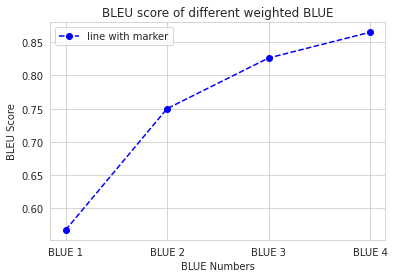

In [33]:
x = ['BLUE 1', 'BLUE 2', 'BLUE 3', 'BLUE 4']
y = np.array(total_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score of different weighted BLUE")
plt.xlabel("BLUE Numbers")
plt.ylabel("BLEU Score")
plt.plot(x, y, linestyle='--', marker='o', color='b', label='line with marker')
plt.legend()
plt.show()

In [34]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_ben_texts = [pair[1] for pair in test_pairs]
len_blue=[]
b1l3,b1l4,b1l5,b1l6,b1l7,b1l8,b1l9,b1l10,b1l11,b1l12,b1l13,b1l14,b1l15,b1l16,b1l17,b1l18,b1l19,b1l20 = ([], ) * 18

In [36]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==3):
        b3=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l3.append(b3)

In [37]:
b1l3

[0.6842105263157895, 0.6842105263157895]

In [38]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==4):
        b4=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l4.append(b4)

In [39]:
b1l4

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75]

In [40]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==5):
        b5=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l5.append(b5)

In [41]:
b1l5

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061]

In [42]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==6):
        b6=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l6.append(b6)

In [43]:
b1l6

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216

In [44]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==7):
        b7=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l7.append(b7)

In [45]:
b1l7

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216

In [46]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==8):
        b8=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l8.append(b8)

In [47]:
b1l8

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216

In [48]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==9):
        b9=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l9.append(b9)

In [49]:
b1l9

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216

In [50]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==10):
        b10=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l10.append(b10)

In [51]:
b1l10

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216

In [52]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==11):
        b11=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l11.append(b11)

In [53]:
b1l11

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216

In [54]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==12):
        b12=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l12.append(b12)

In [55]:
b1l12

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216

In [56]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==13):
        b13=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l13.append(b13)

In [57]:
b1l13

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216

In [58]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==14):
        b14=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l14.append(b14)

In [59]:
b1l14

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216

In [60]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==15):
        b15=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l15.append(b15)

In [61]:
b1l15

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216

In [62]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==16):
        b16=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l16.append(b16)

In [63]:
b1l16

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216

In [64]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==17):
        b17=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l17.append(b17)

In [65]:
b1l17

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216

In [66]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==18):
        b18=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l18.append(b18)

In [67]:
b1l18

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216

In [68]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==19):
        b19=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l19.append(b19)

In [69]:
b1l19

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216

In [70]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==20):
        b20=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(1,0,0,0))
        b1l20.append(b20)

In [71]:
b1l20

[0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216

In [72]:
blu1l3= [0.6842105263157895, 0.6842105263157895]

blu1l4= [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75]

blu1l5= [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061]


blu1l6= [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216216216216216,
 0.5625,
 0.6176470588235294,
 0.53125]

blu1l7= [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216216216216216,
 0.5625,
 0.6176470588235294,
 0.53125,
 0.4523809523809524,
 0.53125,
 0.5405405405405406,
 0.5405405405405406,
 0.4772727272727273,
 0.4782608695652174,
 0.6052631578947368,
 0.4878048780487805,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.43243243243243246,
 0.42857142857142855,
 0.4,
 0.4444444444444444,
 0.675]

blu1l8= [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216216216216216,
 0.5625,
 0.6176470588235294,
 0.53125,
 0.4523809523809524,
 0.53125,
 0.5405405405405406,
 0.5405405405405406,
 0.4772727272727273,
 0.4782608695652174,
 0.6052631578947368,
 0.4878048780487805,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.43243243243243246,
 0.42857142857142855,
 0.4,
 0.4444444444444444,
 0.675,
 0.4318181818181818,
 0.45454545454545453,
 0.5853658536585366,
 0.575,
 0.4473684210526316,
 0.5625,
 0.5526315789473685,
 0.39215686274509803,
 0.575,
 0.6122448979591837,
 0.4090909090909091,
 0.425531914893617,
 0.5681818181818182,
 0.5833333333333334]

blu1l9= [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216216216216216,
 0.5625,
 0.6176470588235294,
 0.53125,
 0.4523809523809524,
 0.53125,
 0.5405405405405406,
 0.5405405405405406,
 0.4772727272727273,
 0.4782608695652174,
 0.6052631578947368,
 0.4878048780487805,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.43243243243243246,
 0.42857142857142855,
 0.4,
 0.4444444444444444,
 0.675,
 0.4318181818181818,
 0.45454545454545453,
 0.5853658536585366,
 0.575,
 0.4473684210526316,
 0.5625,
 0.5526315789473685,
 0.39215686274509803,
 0.575,
 0.6122448979591837,
 0.4090909090909091,
 0.425531914893617,
 0.5681818181818182,
 0.5833333333333334,
 0.3617021276595745,
 0.52,
 0.5098039215686274]

blu1l10=  [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216216216216216,
 0.5625,
 0.6176470588235294,
 0.53125,
 0.4523809523809524,
 0.53125,
 0.5405405405405406,
 0.5405405405405406,
 0.4772727272727273,
 0.4782608695652174,
 0.6052631578947368,
 0.4878048780487805,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.43243243243243246,
 0.42857142857142855,
 0.4,
 0.4444444444444444,
 0.675,
 0.4318181818181818,
 0.45454545454545453,
 0.5853658536585366,
 0.575,
 0.4473684210526316,
 0.5625,
 0.5526315789473685,
 0.39215686274509803,
 0.575,
 0.6122448979591837,
 0.4090909090909091,
 0.425531914893617,
 0.5681818181818182,
 0.5833333333333334,
 0.3617021276595745,
 0.52,
 0.5098039215686274,
 0.47058823529411764,
 0.40384615384615385]

blu1l11=  [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216216216216216,
 0.5625,
 0.6176470588235294,
 0.53125,
 0.4523809523809524,
 0.53125,
 0.5405405405405406,
 0.5405405405405406,
 0.4772727272727273,
 0.4782608695652174,
 0.6052631578947368,
 0.4878048780487805,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.43243243243243246,
 0.42857142857142855,
 0.4,
 0.4444444444444444,
 0.675,
 0.4318181818181818,
 0.45454545454545453,
 0.5853658536585366,
 0.575,
 0.4473684210526316,
 0.5625,
 0.5526315789473685,
 0.39215686274509803,
 0.575,
 0.6122448979591837,
 0.4090909090909091,
 0.425531914893617,
 0.5681818181818182,
 0.5833333333333334,
 0.3617021276595745,
 0.52,
 0.5098039215686274,
 0.47058823529411764,
 0.40384615384615385,
 0.3181818181818182,
 0.4262295081967213]

blu1l12=  [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216216216216216,
 0.5625,
 0.6176470588235294,
 0.53125,
 0.4523809523809524,
 0.53125,
 0.5405405405405406,
 0.5405405405405406,
 0.4772727272727273,
 0.4782608695652174,
 0.6052631578947368,
 0.4878048780487805,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.43243243243243246,
 0.42857142857142855,
 0.4,
 0.4444444444444444,
 0.675,
 0.4318181818181818,
 0.45454545454545453,
 0.5853658536585366,
 0.575,
 0.4473684210526316,
 0.5625,
 0.5526315789473685,
 0.39215686274509803,
 0.575,
 0.6122448979591837,
 0.4090909090909091,
 0.425531914893617,
 0.5681818181818182,
 0.5833333333333334,
 0.3617021276595745,
 0.52,
 0.5098039215686274,
 0.47058823529411764,
 0.40384615384615385,
 0.3181818181818182,
 0.4262295081967213,
 0.43283582089552236]

blu1l13=  [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216216216216216,
 0.5625,
 0.6176470588235294,
 0.53125,
 0.4523809523809524,
 0.53125,
 0.5405405405405406,
 0.5405405405405406,
 0.4772727272727273,
 0.4782608695652174,
 0.6052631578947368,
 0.4878048780487805,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.43243243243243246,
 0.42857142857142855,
 0.4,
 0.4444444444444444,
 0.675,
 0.4318181818181818,
 0.45454545454545453,
 0.5853658536585366,
 0.575,
 0.4473684210526316,
 0.5625,
 0.5526315789473685,
 0.39215686274509803,
 0.575,
 0.6122448979591837,
 0.4090909090909091,
 0.425531914893617,
 0.5681818181818182,
 0.5833333333333334,
 0.3617021276595745,
 0.52,
 0.5098039215686274,
 0.47058823529411764,
 0.40384615384615385,
 0.3181818181818182,
 0.4262295081967213,
 0.43283582089552236]

blu1l14=  [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216216216216216,
 0.5625,
 0.6176470588235294,
 0.53125,
 0.4523809523809524,
 0.53125,
 0.5405405405405406,
 0.5405405405405406,
 0.4772727272727273,
 0.4782608695652174,
 0.6052631578947368,
 0.4878048780487805,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.43243243243243246,
 0.42857142857142855,
 0.4,
 0.4444444444444444,
 0.675,
 0.4318181818181818,
 0.45454545454545453,
 0.5853658536585366,
 0.575,
 0.4473684210526316,
 0.5625,
 0.5526315789473685,
 0.39215686274509803,
 0.575,
 0.6122448979591837,
 0.4090909090909091,
 0.425531914893617,
 0.5681818181818182,
 0.5833333333333334,
 0.3617021276595745,
 0.52,
 0.5098039215686274,
 0.47058823529411764,
 0.40384615384615385,
 0.3181818181818182,
 0.4262295081967213,
 0.43283582089552236]

blu1l15=  [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216216216216216,
 0.5625,
 0.6176470588235294,
 0.53125,
 0.4523809523809524,
 0.53125,
 0.5405405405405406,
 0.5405405405405406,
 0.4772727272727273,
 0.4782608695652174,
 0.6052631578947368,
 0.4878048780487805,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.43243243243243246,
 0.42857142857142855,
 0.4,
 0.4444444444444444,
 0.675,
 0.4318181818181818,
 0.45454545454545453,
 0.5853658536585366,
 0.575,
 0.4473684210526316,
 0.5625,
 0.5526315789473685,
 0.39215686274509803,
 0.575,
 0.6122448979591837,
 0.4090909090909091,
 0.425531914893617,
 0.5681818181818182,
 0.5833333333333334,
 0.3617021276595745,
 0.52,
 0.5098039215686274,
 0.47058823529411764,
 0.40384615384615385,
 0.3181818181818182,
 0.4262295081967213,
 0.43283582089552236]

blu1l16=  [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216216216216216,
 0.5625,
 0.6176470588235294,
 0.53125,
 0.4523809523809524,
 0.53125,
 0.5405405405405406,
 0.5405405405405406,
 0.4772727272727273,
 0.4782608695652174,
 0.6052631578947368,
 0.4878048780487805,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.43243243243243246,
 0.42857142857142855,
 0.4,
 0.4444444444444444,
 0.675,
 0.4318181818181818,
 0.45454545454545453,
 0.5853658536585366,
 0.575,
 0.4473684210526316,
 0.5625,
 0.5526315789473685,
 0.39215686274509803,
 0.575,
 0.6122448979591837,
 0.4090909090909091,
 0.425531914893617,
 0.5681818181818182,
 0.5833333333333334,
 0.3617021276595745,
 0.52,
 0.5098039215686274,
 0.47058823529411764,
 0.40384615384615385,
 0.3181818181818182,
 0.4262295081967213,
 0.43283582089552236]

blu1l17=  [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216216216216216,
 0.5625,
 0.6176470588235294,
 0.53125,
 0.4523809523809524,
 0.53125,
 0.5405405405405406,
 0.5405405405405406,
 0.4772727272727273,
 0.4782608695652174,
 0.6052631578947368,
 0.4878048780487805,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.43243243243243246,
 0.42857142857142855,
 0.4,
 0.4444444444444444,
 0.675,
 0.4318181818181818,
 0.45454545454545453,
 0.5853658536585366,
 0.575,
 0.4473684210526316,
 0.5625,
 0.5526315789473685,
 0.39215686274509803,
 0.575,
 0.6122448979591837,
 0.4090909090909091,
 0.425531914893617,
 0.5681818181818182,
 0.5833333333333334,
 0.3617021276595745,
 0.52,
 0.5098039215686274,
 0.47058823529411764,
 0.40384615384615385,
 0.3181818181818182,
 0.4262295081967213,
 0.43283582089552236]

blu1l18=  [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216216216216216,
 0.5625,
 0.6176470588235294,
 0.53125,
 0.4523809523809524,
 0.53125,
 0.5405405405405406,
 0.5405405405405406,
 0.4772727272727273,
 0.4782608695652174,
 0.6052631578947368,
 0.4878048780487805,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.43243243243243246,
 0.42857142857142855,
 0.4,
 0.4444444444444444,
 0.675,
 0.4318181818181818,
 0.45454545454545453,
 0.5853658536585366,
 0.575,
 0.4473684210526316,
 0.5625,
 0.5526315789473685,
 0.39215686274509803,
 0.575,
 0.6122448979591837,
 0.4090909090909091,
 0.425531914893617,
 0.5681818181818182,
 0.5833333333333334,
 0.3617021276595745,
 0.52,
 0.5098039215686274,
 0.47058823529411764,
 0.40384615384615385,
 0.3181818181818182,
 0.4262295081967213,
 0.43283582089552236]

blu1l19=  [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216216216216216,
 0.5625,
 0.6176470588235294,
 0.53125,
 0.4523809523809524,
 0.53125,
 0.5405405405405406,
 0.5405405405405406,
 0.4772727272727273,
 0.4782608695652174,
 0.6052631578947368,
 0.4878048780487805,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.43243243243243246,
 0.42857142857142855,
 0.4,
 0.4444444444444444,
 0.675,
 0.4318181818181818,
 0.45454545454545453,
 0.5853658536585366,
 0.575,
 0.4473684210526316,
 0.5625,
 0.5526315789473685,
 0.39215686274509803,
 0.575,
 0.6122448979591837,
 0.4090909090909091,
 0.425531914893617,
 0.5681818181818182,
 0.5833333333333334,
 0.3617021276595745,
 0.52,
 0.5098039215686274,
 0.47058823529411764,
 0.40384615384615385,
 0.3181818181818182,
 0.4262295081967213,
 0.43283582089552236]

blu1l20=  [0.6842105263157895,
 0.6842105263157895,
 0.5555555555555556,
 0.72,
 0.6818181818181818,
 0.625,
 0.72,
 0.56,
 0.7142857142857143,
 0.75,
 0.6774193548387096,
 0.6111111111111112,
 0.6551724137931034,
 0.6666666666666666,
 0.6451612903225806,
 0.53125,
 0.6896551724137931,
 0.48484848484848486,
 0.4838709677419355,
 0.6428571428571429,
 0.7857142857142857,
 0.68,
 0.7037037037037037,
 0.6666666666666666,
 0.6896551724137931,
 0.625,
 0.5625,
 0.5714285714285714,
 0.6551724137931034,
 0.68,
 0.696969696969697,
 0.5666666666666667,
 0.6060606060606061,
 0.65625,
 0.5,
 0.48484848484848486,
 0.6896551724137931,
 0.5675675675675675,
 0.625,
 0.4594594594594595,
 0.6176470588235294,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.7419354838709677,
 0.5,
 0.5333333333333333,
 0.7027027027027027,
 0.6060606060606061,
 0.6764705882352942,
 0.45,
 0.5806451612903226,
 0.5945945945945946,
 0.5428571428571428,
 0.5806451612903226,
 0.65625,
 0.6111111111111112,
 0.45714285714285713,
 0.6216216216216216,
 0.5625,
 0.6176470588235294,
 0.53125,
 0.4523809523809524,
 0.53125,
 0.5405405405405406,
 0.5405405405405406,
 0.4772727272727273,
 0.4782608695652174,
 0.6052631578947368,
 0.4878048780487805,
 0.6486486486486487,
 0.4418604651162791,
 0.5,
 0.43243243243243246,
 0.42857142857142855,
 0.4,
 0.4444444444444444,
 0.675,
 0.4318181818181818,
 0.45454545454545453,
 0.5853658536585366,
 0.575,
 0.4473684210526316,
 0.5625,
 0.5526315789473685,
 0.39215686274509803,
 0.575,
 0.6122448979591837,
 0.4090909090909091,
 0.425531914893617,
 0.5681818181818182,
 0.5833333333333334,
 0.3617021276595745,
 0.52,
 0.5098039215686274,
 0.47058823529411764,
 0.40384615384615385,
 0.3181818181818182,
 0.4262295081967213,
 0.43283582089552236]

In [73]:
len_blue=[]
len_blue.append(sum(blu1l3)/len(blu1l3))
len_blue.append(sum(blu1l4)/len(blu1l4))
len_blue.append(sum(blu1l5)/len(blu1l5))
len_blue.append(sum(blu1l6)/len(blu1l6))
len_blue.append(sum(blu1l7)/len(blu1l7))
len_blue.append(sum(blu1l8)/len(blu1l8))
len_blue.append(sum(blu1l9)/len(blu1l9))
len_blue.append(sum(blu1l10)/len(blu1l10))
len_blue.append(sum(blu1l11)/len(blu1l11))
len_blue.append(sum(blu1l12)/len(blu1l12))
len_blue.append(sum(blu1l13)/len(blu1l13))
len_blue.append(sum(blu1l14)/len(blu1l14))
len_blue.append(sum(blu1l15)/len(blu1l15))
len_blue.append(sum(blu1l16)/len(blu1l16))
len_blue.append(sum(blu1l17)/len(blu1l17))
len_blue.append(sum(blu1l18)/len(blu1l18))
len_blue.append(sum(blu1l19)/len(blu1l19))
len_blue.append(sum(blu1l20)/len(blu1l20))

In [74]:
len_blue

[0.6842105263157895,
 0.669508050429103,
 0.6446251785545954,
 0.6133925027760293,
 0.5912129007380837,
 0.5792323422151813,
 0.5755882266634198,
 0.5727352156924242,
 0.5686841136216534,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921]

In [ ]:
len_blue=[0.6842105263157895,
 0.669508050429103,
 0.6446251785545954,
 0.6133925027760293,
 0.5912129007380837,
 0.5792323422151813,
 0.5755882266634198,
 0.5727352156924242,
 0.5686841136216534,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921]

In [75]:
len_blue

[0.6842105263157895,
 0.669508050429103,
 0.6446251785545954,
 0.6133925027760293,
 0.5912129007380837,
 0.5792323422151813,
 0.5755882266634198,
 0.5727352156924242,
 0.5686841136216534,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921,
 0.5673256306943921]

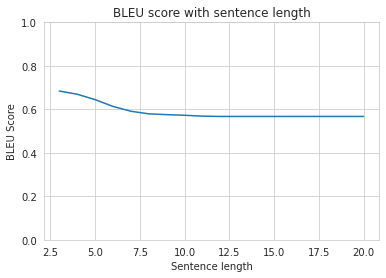

In [76]:
x = np.array([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
y = np.array(len_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score with sentence length")
plt.xlabel("Sentence length")
plt.ylabel("BLEU Score")
plt.ylim(0,1)
plt.plot(x, y)
plt.show()

In [77]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_deu_texts = [pair[1] for pair in test_pairs]
len_blue=[]
b4l3,b4l4,b4l5,b4l6,b4l7,b4l8,b4l9,b4l10,b4l11,b4l12,b4l13,b4l14,b4l15,b4l16,b4l17,b4l18,b4l19,b4l20 = ([], ) * 18

In [78]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==3):
        b3=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l3.append(b3)

In [79]:
b4l3

[0.9094889729229877, 0.9094889729229877]

In [80]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==4):
        b4=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l4.append(b4)

In [81]:
b4l4

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996]

In [82]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==5):
        b5=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l5.append(b5)

In [83]:
b4l5

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413]

In [84]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==6):
        b6=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l6.append(b6)

In [85]:
b4l6

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0

In [86]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==7):
        b7=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l7.append(b7)

In [87]:
b4l7

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0

In [88]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==8):
        b8=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l8.append(b8)

In [89]:
b4l8

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0

In [90]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==9):
        b9=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l9.append(b9)

In [91]:
b4l9

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0

In [92]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==10):
        b10=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l10.append(b10)

In [93]:
b4l10

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0

In [94]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==11):
        b11=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l11.append(b11)

In [95]:
b4l11

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0

In [96]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==12):
        b12=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l12.append(b12)

In [97]:
b4l12

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0

In [98]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==13):
        b13=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l13.append(b13)

In [99]:
b4l13

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0

In [100]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==14):
        b14=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l14.append(b14)

In [101]:
b4l14

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0

In [102]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==15):
        b15=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l15.append(b15)

In [103]:
b4l15

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0

In [104]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==16):
        b16=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l16.append(b16)

In [105]:
b4l16

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0

In [106]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==17):
        b17=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l17.append(b17)

In [107]:
b4l17

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0

In [108]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==18):
        b18=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l18.append(b18)

In [109]:
b4l18

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0

In [110]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==19):
        b19=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l19.append(b19)

In [111]:
b4l19

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0

In [112]:
for i in range(100):
      input_sentence = test_eng_texts[i]
      translated = decode_sequence(input_sentence)
      if(len(translated.split())==20):
        b20=bleu.sentence_bleu(test_ben_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
        b4l20.append(b20)

In [113]:
b4l20

[0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0

In [115]:
blu4l3= [0.9094889729229877, 0.9094889729229877]

blu4l4= [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996]

blu4l5= [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413]
 
blu4l6= [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0.8823258718645413,
 0.9069059051687636,
 0.81903625881272,
 0.8729265501754102,
 0.8781227710041801,
 0.8583637909493895,
 0.8729265501754102,
 0.9000514359196271,
 0.8841583342199357,
 0.8222672338010394,
 0.8879357216148701,
 0.8660254037844387,
 0.8865129711365626,
 0.8537382425870722]

blu4l7= [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0.8823258718645413,
 0.9069059051687636,
 0.81903625881272,
 0.8729265501754102,
 0.8781227710041801,
 0.8583637909493895,
 0.8729265501754102,
 0.9000514359196271,
 0.8841583342199357,
 0.8222672338010394,
 0.8879357216148701,
 0.8660254037844387,
 0.8865129711365626,
 0.8537382425870722,
 0.8201174971518101,
 0.8537382425870722,
 0.857446570984926,
 0.857446570984926,
 0.831173435395861,
 0.8316033157750904,
 0.882035489770961,
 0.8357214223469315,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.8109228996775397,
 0.8091067115702212,
 0.7952707287670506,
 0.816496580927726,
 0.9064126192070304]


blu4l8= [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0.8823258718645413,
 0.9069059051687636,
 0.81903625881272,
 0.8729265501754102,
 0.8781227710041801,
 0.8583637909493895,
 0.8729265501754102,
 0.9000514359196271,
 0.8841583342199357,
 0.8222672338010394,
 0.8879357216148701,
 0.8660254037844387,
 0.8865129711365626,
 0.8537382425870722,
 0.8201174971518101,
 0.8537382425870722,
 0.857446570984926,
 0.857446570984926,
 0.831173435395861,
 0.8316033157750904,
 0.882035489770961,
 0.8357214223469315,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.8109228996775397,
 0.8091067115702212,
 0.7952707287670506,
 0.816496580927726,
 0.9064126192070304,
 0.8106347763776058,
 0.8210967436686386,
 0.8746954073710493,
 0.8707970741827025,
 0.8178362024635121,
 0.8660254037844387,
 0.862201798696238,
 0.791343345890486,
 0.8707970741827025,
 0.884568141205612,
 0.7997513045108656,
 0.8076682939508287,
 0.8682041012598415,
 0.8739351325046805]
 

blu4l9= [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0.8823258718645413,
 0.9069059051687636,
 0.81903625881272,
 0.8729265501754102,
 0.8781227710041801,
 0.8583637909493895,
 0.8729265501754102,
 0.9000514359196271,
 0.8841583342199357,
 0.8222672338010394,
 0.8879357216148701,
 0.8660254037844387,
 0.8865129711365626,
 0.8537382425870722,
 0.8201174971518101,
 0.8537382425870722,
 0.857446570984926,
 0.857446570984926,
 0.831173435395861,
 0.8316033157750904,
 0.882035489770961,
 0.8357214223469315,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.8109228996775397,
 0.8091067115702212,
 0.7952707287670506,
 0.816496580927726,
 0.9064126192070304,
 0.8106347763776058,
 0.8210967436686386,
 0.8746954073710493,
 0.8707970741827025,
 0.8178362024635121,
 0.8660254037844387,
 0.862201798696238,
 0.791343345890486,
 0.8707970741827025,
 0.884568141205612,
 0.7997513045108656,
 0.8076682939508287,
 0.8682041012598415,
 0.8739351325046805,
 0.7755106492019573,
 0.8491821094987799,
 0.844988489445517]

blu4l10=  [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0.8823258718645413,
 0.9069059051687636,
 0.81903625881272,
 0.8729265501754102,
 0.8781227710041801,
 0.8583637909493895,
 0.8729265501754102,
 0.9000514359196271,
 0.8841583342199357,
 0.8222672338010394,
 0.8879357216148701,
 0.8660254037844387,
 0.8865129711365626,
 0.8537382425870722,
 0.8201174971518101,
 0.8537382425870722,
 0.857446570984926,
 0.857446570984926,
 0.831173435395861,
 0.8316033157750904,
 0.882035489770961,
 0.8357214223469315,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.8109228996775397,
 0.8091067115702212,
 0.7952707287670506,
 0.816496580927726,
 0.9064126192070304,
 0.8106347763776058,
 0.8210967436686386,
 0.8746954073710493,
 0.8707970741827025,
 0.8178362024635121,
 0.8660254037844387,
 0.862201798696238,
 0.791343345890486,
 0.8707970741827025,
 0.884568141205612,
 0.7997513045108656,
 0.8076682939508287,
 0.8682041012598415,
 0.8739351325046805,
 0.7755106492019573,
 0.8491821094987799,
 0.844988489445517,
 0.8282477531331041,
 0.7971755824799469]

blu4l11=  [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0.8823258718645413,
 0.9069059051687636,
 0.81903625881272,
 0.8729265501754102,
 0.8781227710041801,
 0.8583637909493895,
 0.8729265501754102,
 0.9000514359196271,
 0.8841583342199357,
 0.8222672338010394,
 0.8879357216148701,
 0.8660254037844387,
 0.8865129711365626,
 0.8537382425870722,
 0.8201174971518101,
 0.8537382425870722,
 0.857446570984926,
 0.857446570984926,
 0.831173435395861,
 0.8316033157750904,
 0.882035489770961,
 0.8357214223469315,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.8109228996775397,
 0.8091067115702212,
 0.7952707287670506,
 0.816496580927726,
 0.9064126192070304,
 0.8106347763776058,
 0.8210967436686386,
 0.8746954073710493,
 0.8707970741827025,
 0.8178362024635121,
 0.8660254037844387,
 0.862201798696238,
 0.791343345890486,
 0.8707970741827025,
 0.884568141205612,
 0.7997513045108656,
 0.8076682939508287,
 0.8682041012598415,
 0.8739351325046805,
 0.7755106492019573,
 0.8491821094987799,
 0.844988489445517,
 0.8282477531331041,
 0.7971755824799469,
 0.7510499815709779,
 0.8079991022503509]

blu4l12=  [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0.8823258718645413,
 0.9069059051687636,
 0.81903625881272,
 0.8729265501754102,
 0.8781227710041801,
 0.8583637909493895,
 0.8729265501754102,
 0.9000514359196271,
 0.8841583342199357,
 0.8222672338010394,
 0.8879357216148701,
 0.8660254037844387,
 0.8865129711365626,
 0.8537382425870722,
 0.8201174971518101,
 0.8537382425870722,
 0.857446570984926,
 0.857446570984926,
 0.831173435395861,
 0.8316033157750904,
 0.882035489770961,
 0.8357214223469315,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.8109228996775397,
 0.8091067115702212,
 0.7952707287670506,
 0.816496580927726,
 0.9064126192070304,
 0.8106347763776058,
 0.8210967436686386,
 0.8746954073710493,
 0.8707970741827025,
 0.8178362024635121,
 0.8660254037844387,
 0.862201798696238,
 0.791343345890486,
 0.8707970741827025,
 0.884568141205612,
 0.7997513045108656,
 0.8076682939508287,
 0.8682041012598415,
 0.8739351325046805,
 0.7755106492019573,
 0.8491821094987799,
 0.844988489445517,
 0.8282477531331041,
 0.7971755824799469,
 0.7510499815709779,
 0.8079991022503509,
 0.8111119480409298]

blu4l13= [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0.8823258718645413,
 0.9069059051687636,
 0.81903625881272,
 0.8729265501754102,
 0.8781227710041801,
 0.8583637909493895,
 0.8729265501754102,
 0.9000514359196271,
 0.8841583342199357,
 0.8222672338010394,
 0.8879357216148701,
 0.8660254037844387,
 0.8865129711365626,
 0.8537382425870722,
 0.8201174971518101,
 0.8537382425870722,
 0.857446570984926,
 0.857446570984926,
 0.831173435395861,
 0.8316033157750904,
 0.882035489770961,
 0.8357214223469315,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.8109228996775397,
 0.8091067115702212,
 0.7952707287670506,
 0.816496580927726,
 0.9064126192070304,
 0.8106347763776058,
 0.8210967436686386,
 0.8746954073710493,
 0.8707970741827025,
 0.8178362024635121,
 0.8660254037844387,
 0.862201798696238,
 0.791343345890486,
 0.8707970741827025,
 0.884568141205612,
 0.7997513045108656,
 0.8076682939508287,
 0.8682041012598415,
 0.8739351325046805,
 0.7755106492019573,
 0.8491821094987799,
 0.844988489445517,
 0.8282477531331041,
 0.7971755824799469,
 0.7510499815709779,
 0.8079991022503509,
 0.8111119480409298]

blu4l14=  [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0.8823258718645413,
 0.9069059051687636,
 0.81903625881272,
 0.8729265501754102,
 0.8781227710041801,
 0.8583637909493895,
 0.8729265501754102,
 0.9000514359196271,
 0.8841583342199357,
 0.8222672338010394,
 0.8879357216148701,
 0.8660254037844387,
 0.8865129711365626,
 0.8537382425870722,
 0.8201174971518101,
 0.8537382425870722,
 0.857446570984926,
 0.857446570984926,
 0.831173435395861,
 0.8316033157750904,
 0.882035489770961,
 0.8357214223469315,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.8109228996775397,
 0.8091067115702212,
 0.7952707287670506,
 0.816496580927726,
 0.9064126192070304,
 0.8106347763776058,
 0.8210967436686386,
 0.8746954073710493,
 0.8707970741827025,
 0.8178362024635121,
 0.8660254037844387,
 0.862201798696238,
 0.791343345890486,
 0.8707970741827025,
 0.884568141205612,
 0.7997513045108656,
 0.8076682939508287,
 0.8682041012598415,
 0.8739351325046805,
 0.7755106492019573,
 0.8491821094987799,
 0.844988489445517,
 0.8282477531331041,
 0.7971755824799469,
 0.7510499815709779,
 0.8079991022503509,
 0.8111119480409298]

blu4l15=  [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0.8823258718645413,
 0.9069059051687636,
 0.81903625881272,
 0.8729265501754102,
 0.8781227710041801,
 0.8583637909493895,
 0.8729265501754102,
 0.9000514359196271,
 0.8841583342199357,
 0.8222672338010394,
 0.8879357216148701,
 0.8660254037844387,
 0.8865129711365626,
 0.8537382425870722,
 0.8201174971518101,
 0.8537382425870722,
 0.857446570984926,
 0.857446570984926,
 0.831173435395861,
 0.8316033157750904,
 0.882035489770961,
 0.8357214223469315,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.8109228996775397,
 0.8091067115702212,
 0.7952707287670506,
 0.816496580927726,
 0.9064126192070304,
 0.8106347763776058,
 0.8210967436686386,
 0.8746954073710493,
 0.8707970741827025,
 0.8178362024635121,
 0.8660254037844387,
 0.862201798696238,
 0.791343345890486,
 0.8707970741827025,
 0.884568141205612,
 0.7997513045108656,
 0.8076682939508287,
 0.8682041012598415,
 0.8739351325046805,
 0.7755106492019573,
 0.8491821094987799,
 0.844988489445517,
 0.8282477531331041,
 0.7971755824799469,
 0.7510499815709779,
 0.8079991022503509,
 0.8111119480409298]

blu4l16=  [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0.8823258718645413,
 0.9069059051687636,
 0.81903625881272,
 0.8729265501754102,
 0.8781227710041801,
 0.8583637909493895,
 0.8729265501754102,
 0.9000514359196271,
 0.8841583342199357,
 0.8222672338010394,
 0.8879357216148701,
 0.8660254037844387,
 0.8865129711365626,
 0.8537382425870722,
 0.8201174971518101,
 0.8537382425870722,
 0.857446570984926,
 0.857446570984926,
 0.831173435395861,
 0.8316033157750904,
 0.882035489770961,
 0.8357214223469315,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.8109228996775397,
 0.8091067115702212,
 0.7952707287670506,
 0.816496580927726,
 0.9064126192070304,
 0.8106347763776058,
 0.8210967436686386,
 0.8746954073710493,
 0.8707970741827025,
 0.8178362024635121,
 0.8660254037844387,
 0.862201798696238,
 0.791343345890486,
 0.8707970741827025,
 0.884568141205612,
 0.7997513045108656,
 0.8076682939508287,
 0.8682041012598415,
 0.8739351325046805,
 0.7755106492019573,
 0.8491821094987799,
 0.844988489445517,
 0.8282477531331041,
 0.7971755824799469,
 0.7510499815709779,
 0.8079991022503509,
 0.8111119480409298]

blu4l17=  [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0.8823258718645413,
 0.9069059051687636,
 0.81903625881272,
 0.8729265501754102,
 0.8781227710041801,
 0.8583637909493895,
 0.8729265501754102,
 0.9000514359196271,
 0.8841583342199357,
 0.8222672338010394,
 0.8879357216148701,
 0.8660254037844387,
 0.8865129711365626,
 0.8537382425870722,
 0.8201174971518101,
 0.8537382425870722,
 0.857446570984926,
 0.857446570984926,
 0.831173435395861,
 0.8316033157750904,
 0.882035489770961,
 0.8357214223469315,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.8109228996775397,
 0.8091067115702212,
 0.7952707287670506,
 0.816496580927726,
 0.9064126192070304,
 0.8106347763776058,
 0.8210967436686386,
 0.8746954073710493,
 0.8707970741827025,
 0.8178362024635121,
 0.8660254037844387,
 0.862201798696238,
 0.791343345890486,
 0.8707970741827025,
 0.884568141205612,
 0.7997513045108656,
 0.8076682939508287,
 0.8682041012598415,
 0.8739351325046805,
 0.7755106492019573,
 0.8491821094987799,
 0.844988489445517,
 0.8282477531331041,
 0.7971755824799469,
 0.7510499815709779,
 0.8079991022503509,
 0.8111119480409298]

blu4l18=  [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0.8823258718645413,
 0.9069059051687636,
 0.81903625881272,
 0.8729265501754102,
 0.8781227710041801,
 0.8583637909493895,
 0.8729265501754102,
 0.9000514359196271,
 0.8841583342199357,
 0.8222672338010394,
 0.8879357216148701,
 0.8660254037844387,
 0.8865129711365626,
 0.8537382425870722,
 0.8201174971518101,
 0.8537382425870722,
 0.857446570984926,
 0.857446570984926,
 0.831173435395861,
 0.8316033157750904,
 0.882035489770961,
 0.8357214223469315,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.8109228996775397,
 0.8091067115702212,
 0.7952707287670506,
 0.816496580927726,
 0.9064126192070304,
 0.8106347763776058,
 0.8210967436686386,
 0.8746954073710493,
 0.8707970741827025,
 0.8178362024635121,
 0.8660254037844387,
 0.862201798696238,
 0.791343345890486,
 0.8707970741827025,
 0.884568141205612,
 0.7997513045108656,
 0.8076682939508287,
 0.8682041012598415,
 0.8739351325046805,
 0.7755106492019573,
 0.8491821094987799,
 0.844988489445517,
 0.8282477531331041,
 0.7971755824799469,
 0.7510499815709779,
 0.8079991022503509,
 0.8111119480409298]

blu4l19=  [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0.8823258718645413,
 0.9069059051687636,
 0.81903625881272,
 0.8729265501754102,
 0.8781227710041801,
 0.8583637909493895,
 0.8729265501754102,
 0.9000514359196271,
 0.8841583342199357,
 0.8222672338010394,
 0.8879357216148701,
 0.8660254037844387,
 0.8865129711365626,
 0.8537382425870722,
 0.8201174971518101,
 0.8537382425870722,
 0.857446570984926,
 0.857446570984926,
 0.831173435395861,
 0.8316033157750904,
 0.882035489770961,
 0.8357214223469315,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.8109228996775397,
 0.8091067115702212,
 0.7952707287670506,
 0.816496580927726,
 0.9064126192070304,
 0.8106347763776058,
 0.8210967436686386,
 0.8746954073710493,
 0.8707970741827025,
 0.8178362024635121,
 0.8660254037844387,
 0.862201798696238,
 0.791343345890486,
 0.8707970741827025,
 0.884568141205612,
 0.7997513045108656,
 0.8076682939508287,
 0.8682041012598415,
 0.8739351325046805,
 0.7755106492019573,
 0.8491821094987799,
 0.844988489445517,
 0.8282477531331041,
 0.7971755824799469,
 0.7510499815709779,
 0.8079991022503509,
 0.8111119480409298]

blu4l20=  [0.9094889729229877,
 0.9094889729229877,
 0.8633400213704505,
 0.9211558703193814,
 0.9086929205428919,
 0.8891397050194614,
 0.9211558703193814,
 0.8650615454144222,
 0.9193227152249185,
 0.9306048591020996,
 0.9072237275077749,
 0.8841583342199357,
 0.89968172894662,
 0.9036020036098448,
 0.8962250436706725,
 0.8537382425870722,
 0.9112929268557941,
 0.8344522897223012,
 0.8340313804889192,
 0.8954237688029468,
 0.94149097734812,
 0.9080865185231703,
 0.9158987350181576,
 0.9036020036098448,
 0.9112929268557941,
 0.8891397050194614,
 0.8660254037844387,
 0.8694417438899827,
 0.89968172894662,
 0.9080865185231703,
 0.913699682574489,
 0.8676247188209203,
 0.8823258718645413,
 0.9000514359196271,
 0.8408964152537145,
 0.8344522897223012,
 0.9112929268557941,
 0.8679693563144288,
 0.8891397050194614,
 0.82330698369719,
 0.8865129711365626,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.9280930821927879,
 0.8408964152537145,
 0.8545740127924681,
 0.9155728503428383,
 0.8823258718645413,
 0.9069059051687636,
 0.81903625881272,
 0.8729265501754102,
 0.8781227710041801,
 0.8583637909493895,
 0.8729265501754102,
 0.9000514359196271,
 0.8841583342199357,
 0.8222672338010394,
 0.8879357216148701,
 0.8660254037844387,
 0.8865129711365626,
 0.8537382425870722,
 0.8201174971518101,
 0.8537382425870722,
 0.857446570984926,
 0.857446570984926,
 0.831173435395861,
 0.8316033157750904,
 0.882035489770961,
 0.8357214223469315,
 0.897433711344091,
 0.8153072164002068,
 0.8408964152537145,
 0.8109228996775397,
 0.8091067115702212,
 0.7952707287670506,
 0.816496580927726,
 0.9064126192070304,
 0.8106347763776058,
 0.8210967436686386,
 0.8746954073710493,
 0.8707970741827025,
 0.8178362024635121,
 0.8660254037844387,
 0.862201798696238,
 0.791343345890486,
 0.8707970741827025,
 0.884568141205612,
 0.7997513045108656,
 0.8076682939508287,
 0.8682041012598415,
 0.8739351325046805,
 0.7755106492019573,
 0.8491821094987799,
 0.844988489445517,
 0.8282477531331041,
 0.7971755824799469,
 0.7510499815709779,
 0.8079991022503509,
 0.8111119480409298]

In [116]:
len_blue=[]
len_blue.append(sum(blu4l3)/len(blu4l3))
len_blue.append(sum(blu4l4)/len(blu4l4))
len_blue.append(sum(blu4l5)/len(blu4l5))
len_blue.append(sum(blu4l6)/len(blu4l6))
len_blue.append(sum(blu4l7)/len(blu4l7))
len_blue.append(sum(blu4l8)/len(blu4l8))
len_blue.append(sum(blu4l9)/len(blu4l9))
len_blue.append(sum(blu4l10)/len(blu4l10))
len_blue.append(sum(blu4l11)/len(blu4l11))
len_blue.append(sum(blu4l12)/len(blu4l12))
len_blue.append(sum(blu4l13)/len(blu4l13))
len_blue.append(sum(blu4l14)/len(blu4l14))
len_blue.append(sum(blu4l15)/len(blu4l15))
len_blue.append(sum(blu4l16)/len(blu4l16))
len_blue.append(sum(blu4l17)/len(blu4l17))
len_blue.append(sum(blu4l18)/len(blu4l18))
len_blue.append(sum(blu4l19)/len(blu4l19))
len_blue.append(sum(blu4l20)/len(blu4l20))

In [117]:
len_blue

[0.9094889729229877,
 0.9037451453158983,
 0.8949599222530172,
 0.8834091977913296,
 0.874775637066764,
 0.8701310270788779,
 0.868649849888453,
 0.8674964853094441,
 0.8657192743316909,
 0.8651732010687833,
 0.8651732010687833,
 0.8651732010687833,
 0.8651732010687833,
 0.8651732010687833,
 0.8651732010687833,
 0.8651732010687833,
 0.8651732010687833,
 0.8651732010687833]

In [ ]:
len_blue= [0.9094889729229877,
 0.9037451453158983,
 0.8949599222530172,
 0.8834091977913296,
 0.874775637066764,
 0.8701310270788779,
 0.868649849888453,
 0.8674964853094441,
 0.8657192743316909,
 0.8651732010687833,
 0.8651732010687833,
 0.8651732010687833,
 0.8651732010687833,
 0.8651732010687833,
 0.8651732010687833,
 0.8651732010687833,
 0.8651732010687833,
 0.8651732010687833]

In [118]:
len(len_blue)

18

In [119]:
len([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

18

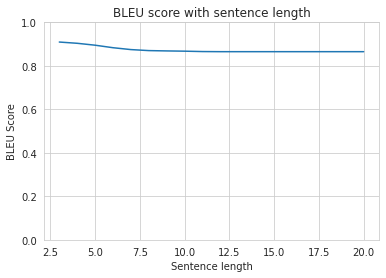

In [120]:
x = np.array([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
y = np.array(len_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score with sentence length")
plt.xlabel("Sentence length")
plt.ylabel("BLEU Score")
plt.ylim(0,1)
plt.plot(x, y)
plt.show()

In [121]:
pip install jiwer

     |████████████████████████████████| 50 kB 8.0 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149865 sha256=57a710f61c38915901735555ec1f4d3e6c469e755040381c0cd64b364abd7be6
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
!unzip /content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/eng-ben.zip

Archive:  /content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/eng-ben.zip
  inflating: eng-ben.h5              


In [122]:
transformer=tf.keras.models.load_model("/content/drive/MyDrive/NMT_6TH_SEM/eng-ben.h5",custom_objects={'PositionalEmbedding': PositionalEmbedding, 'TransformerEncoder': TransformerEncoder, 'TransformerDecoder': TransformerDecoder})

In [123]:
import jiwer
test_eng_texts = [pair[0] for pair in test_pairs]
test_ben_texts = [pair[1] for pair in test_pairs]
werlist=[]
for i in range(100):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("bengali : ",test_ben_texts[i])
    print("predicted: ",translated)
    werscore = jiwer.wer(test_ben_texts[i], translated)
    print("wer:", werscore)
    werlist.append(werscore)    
    print("____________________________________________________________________________") 

1
english:  It doesn't surprise me.
bengali :  [start] এটা আমাকে অবাক করেনি। [end]
predicted:  [start] এতে আমি অবাক হইনি। [end]
wer: 0.5
____________________________________________________________________________
2
english:  I don't get it.
bengali :  [start] আমি ঠিক বুঝতে পরছি না। [end]
predicted:  [start] আমি এটা কিভাবে ব্যাখ্যা করি। [end]
wer: 0.5714285714285714
____________________________________________________________________________
3
english:  Tom and I were alone.
bengali :  [start] আমি আর টম একলা ছিলাম। [end]
predicted:  [start] টম আর কোনো বাচ্চাই ওটা করতে চায়। [end]
wer: 0.8571428571428571
____________________________________________________________________________
4
english:  Don't wait.
bengali :  [start] অপেক্ষা করবি না। [end]
predicted:  [start] অপেক্ষা করবেন না। [end]
wer: 0.2
____________________________________________________________________________
5
english:  I want to know where Tom is.
bengali :  [start] আমি চাই টম কোথায় আছে। [end]
predicted:  [start] আমি কখন

In [124]:
werlist

[0.5,
 0.5714285714285714,
 0.8571428571428571,
 0.2,
 0.7142857142857143,
 0.5,
 0.6666666666666666,
 0.3333333333333333,
 0.16666666666666666,
 0.5714285714285714,
 0.5,
 0.2,
 0.2,
 0.75,
 0.4,
 0.5,
 0.16666666666666666,
 0.16666666666666666,
 0.7777777777777778,
 0.8181818181818182,
 0.6666666666666666,
 0.7142857142857143,
 0.8,
 0.5714285714285714,
 0.25,
 1.1428571428571428,
 0.25,
 0.3333333333333333,
 0.4,
 0.5,
 0.8,
 0.4,
 0.4,
 0.14285714285714285,
 0.375,
 0.8,
 0.16666666666666666,
 0.6666666666666666,
 0.6,
 0.125,
 0.25,
 0.8571428571428571,
 0.3333333333333333,
 0.3333333333333333,
 0.0,
 0.2,
 0.4,
 0.8,
 0.36363636363636365,
 0.5,
 0.7142857142857143,
 0.5555555555555556,
 0.7142857142857143,
 0.4,
 0.125,
 0.5,
 0.3333333333333333,
 0.2,
 0.5,
 0.2,
 1.0,
 0.8888888888888888,
 0.5,
 0.4,
 0.2222222222222222,
 0.5,
 0.5,
 0.4,
 0.75,
 0.25,
 0.75,
 0.2,
 0.4,
 0.16666666666666666,
 1.0,
 0.7777777777777778,
 0.16666666666666666,
 0.25,
 0.2,
 0.16666666666666666,
 0

In [125]:
print(sum(werlist)/len(werlist))

0.4482507215007214


In [126]:
 !pip install -U nltk

     |████████████████████████████████| 1.5 MB 30.9 MB/s 
     |████████████████████████████████| 749 kB 63.1 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [127]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
%matplotlib inline
from nltk.translate.meteor_score import single_meteor_score
test_eng_texts = [pair[0] for pair in test_pairs]
test_ben_texts = [pair[1] for pair in test_pairs]
metlist=[]
for i in range(100):
    input_sentence = test_eng_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("english: ",test_eng_texts[i]) 
    print("bengali : ",test_ben_texts[i])
    print("predicted: ",translated)
    metscore = single_meteor_score(word_tokenize(test_ben_texts[i]), word_tokenize(translated))
    print("meteor score:", metscore)
    metlist.append(metscore)    
    print("____________________________________________________________________________") 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
1
english:  It doesn't surprise me.
bengali :  [start] এটা আমাকে অবাক করেনি। [end]
predicted:  [start] এতে আমি অবাক হইনি। [end]
meteor score: 0.6724489795918367
____________________________________________________________________________
2
english:  I don't get it.
bengali :  [start] আমি ঠিক বুঝতে পরছি না। [end]
predicted:  [start] আমি এটা কিভাবে ব্যাখ্যা করি। [end]
meteor score: 0.6289424860853432
____________________________________________________________________________
3
english:  Tom and I were alone.
bengali :  [start] আমি আর টম একলা ছিলাম। [end]
predicted:  [start] টম আর কোনো বাচ্চাই ওটা করতে চায়। [end]
meteor score: 0.6696428571428572
____________________________________________________________________________
4
english:  Don't wait.
bengali :  [start] অপেক্ষা করবি ন

In [128]:
metlist

[0.6724489795918367,
 0.6289424860853432,
 0.6696428571428572,
 0.8819444444444444,
 0.7817109144542774,
 0.6724489795918367,
 0.5888888888888889,
 0.78677398989899,
 0.8840236686390531,
 0.5813754073057795,
 0.854119425547997,
 0.8819444444444444,
 0.8819444444444444,
 0.49486461251167135,
 0.7687074829931974,
 0.7059558517284465,
 0.9041027559546079,
 0.8211575489862951,
 0.4600694444444444,
 0.3774928774928775,
 0.6289424860853432,
 0.6232763375620519,
 0.7519964507542148,
 0.6405895691609977,
 0.8369747899159665,
 0.546706487473038,
 0.864795918367347,
 0.7890166487004432,
 0.8722527472527472,
 0.755560651226783,
 0.7519964507542148,
 0.7687074829931974,
 0.7687074829931974,
 0.9054545454545455,
 0.7170781893004116,
 0.7519964507542148,
 0.8950617283950617,
 0.7150900900900901,
 0.7602601480152501,
 0.9139118457300276,
 0.7647286821705428,
 0.5305305305305306,
 0.8745874587458746,
 0.7789062500000001,
 0.9995,
 0.8819444444444444,
 0.78677398989899,
 0.647130647130647,
 0.740740740

In [129]:
print(sum(metlist)/len(metlist))

0.7389431919945072


# BENGALI TO ENGLISH

In [130]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import warnings
warnings.filterwarnings('ignore')

In [131]:
# text_file ="/content/drive/MyDrive/NLP_Data/ben.txt"
text_file = "/content/drive/MyDrive/NMT_6TH_SEM/ben.txt"

In [132]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, deu = line.split("\t")[:2]
    eng = "[start] " + eng + " [end]"
    text_pairs.append((eng, deu))
  
print(text_pairs[1])

('[start] Go. [end]', 'যান।')


In [133]:
for i in range(5):
    print(text_pairs[i])

('[start] Go. [end]', 'যাও।')
('[start] Go. [end]', 'যান।')
('[start] Go. [end]', 'যা।')
('[start] Run! [end]', 'পালাও!')
('[start] Run! [end]', 'পালান!')


In [134]:
random.shuffle(text_pairs)
train_pairs = text_pairs[:2000]
val_pairs = text_pairs[2000 : 2500]
test_pairs = text_pairs[2500 : 3000]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

4617 total pairs
2000 training pairs
500 validation pairs
500 test pairs


In [135]:
import pickle

In [136]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/input_eng.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT_6TH_SEM/output_eng.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_eng = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_eng = TextVectorization.from_config(pickle_obj_eng["config"])
vector_eng.set_vocabulary(pickle_obj_eng["vocabulary"])
vector_eng.set_weights(pickle_obj_eng["weights"])

# NOW "vector" can be used in same way

In [137]:
# TO LOAD VECTOR OBJECT FROM PICKLE FILE
# VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT/text vectors/output_ben.pkl"
VECTOR_OBJECT_PATH="/content/drive/MyDrive/NMT_6TH_SEM/input_ben.pkl"

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

pickle_obj_ben = pickle.load(open(VECTOR_OBJECT_PATH, "rb"))
vector_ben = TextVectorization.from_config(pickle_obj_ben["config"])
vector_ben.set_vocabulary(pickle_obj_ben["vocabulary"])
vector_ben.set_weights(pickle_obj_ben["weights"])

# NOW "vector" can be used in same way

In [138]:
def format_dataset(eng, ben):
    eng = vector_eng(eng)
    ben = vector_ben(ben)
    return ({"encoder_inputs": ben, "decoder_inputs": eng[:, :-1],}, eng[:, 1:])

vocab_size = 100000
sequence_length = 20
batch_size = 128

def make_dataset(pairs):
    eng_texts, ben_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    ben_texts = list(ben_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, ben_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [139]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (128, 20)
inputs["decoder_inputs"].shape: (128, 20)
targets.shape: (128, 20)


In [140]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads,
        })
        return config

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'latent_dim': self.latent_dim,
            'num_heads': self.num_heads,
        })
        return config

In [141]:
embed_dim = 256
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [142]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_2 (Positi  (None, None, 256)   25605120    ['encoder_inputs[0][0]']         
 onalEmbedding)                                                                                   
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_1 (Transfo  (None, None, 256)   2630144     ['positional_embedding_

In [143]:
epochs = 100  # This should be at least 30 for convergence

transformer.compile("adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/100
16/16 [==============================] - 10s 446ms/step - loss: 3.0611 - accuracy: 0.2763 - val_loss: 2.2491 - val_accuracy: 0.3033
Epoch 2/100
16/16 [==============================] - 6s 403ms/step - loss: 1.7383 - accuracy: 0.3309 - val_loss: 1.5837 - val_accuracy: 0.3547
Epoch 3/100
16/16 [==============================] - 6s 403ms/step - loss: 1.4082 - accuracy: 0.3583 - val_loss: 1.4356 - val_accuracy: 0.3684
Epoch 4/100
16/16 [==============================] - 6s 405ms/step - loss: 1.2763 - accuracy: 0.3877 - val_loss: 1.3460 - val_accuracy: 0.3924
Epoch 5/100
16/16 [==============================] - 7s 405ms/step - loss: 1.1796 - accuracy: 0.4146 - val_loss: 1.2816 - val_accuracy: 0.4082
Epoch 6/100
16/16 [==============================] - 7s 406ms/step - loss: 1.0868 - accuracy: 0.4438 - val_loss: 1.2198 - val_accuracy: 0.4255
Epoch 7/100
16/16 [==============================] - 6s 407ms/step - loss: 0.9968 - accuracy: 0.4736 - val_loss: 1.1729 - val_accuracy: 0.445

In [144]:
transformer.save('/content/drive/MyDrive/NMT_6TH_SEM/beg-eng.h5')

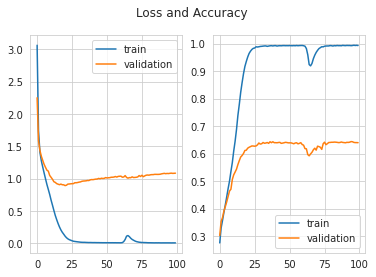

In [145]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Loss and Accuracy')
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train','validation'])
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['train','validation'])

In [146]:
eng_vocab = vector_eng.get_vocabulary()
eng_index_lookup = dict(zip(range(len(eng_vocab)), eng_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = vector_ben([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vector_eng([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = eng_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence



In [147]:
import nltk.translate.bleu_score as bleu
test_eng_texts = [pair[0] for pair in test_pairs]
test_ben_texts = [pair[1] for pair in test_pairs]
blue1=[]
blue2=[]
blue3=[]
blue4=[]
for i in range(100):
    input_sentence = test_ben_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("bengali: ",test_ben_texts[i]) 
    print("english : ",test_eng_texts[i])
    print("predicted: ",translated)
    print('Cumulative 1-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(1, 0, 0, 0))))
    print('Cumulative 2-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.5, 0.5, 0, 0))))
    print('Cumulative 3-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))))
    print('Cumulative 4-gram BLEU score: {:.4f}'.format(bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))))
    bluescore1=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(1, 0, 0, 0))
    blue1.append(bluescore1)

    bluescore2=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.5, 0.5, 0, 0))
    blue2.append(bluescore2)

    bluescore3=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.33, 0.33, 0.33, 0))
    blue3.append(bluescore3)

    bluescore4=bleu.sentence_bleu(test_eng_texts[i], translated, weights=(0.25, 0.25, 0.25, 0.25))
    blue4.append(bluescore4)    
    print("____________________________________________________________________________") 

1
bengali:  আমাদের অবিলম্বে সাহায্যের প্রয়োজন।
english :  [start] We need help immediately. [end]
predicted:  [start] i want to drive [end]
Cumulative 1-gram BLEU score: 0.3793
Cumulative 2-gram BLEU score: 0.6159
Cumulative 3-gram BLEU score: 0.7262
Cumulative 4-gram BLEU score: 0.7848
____________________________________________________________________________
2
bengali:  ওটা শুধু রক্ত।
english :  [start] It's only blood. [end]
predicted:  [start] thats just arrived [end]
Cumulative 1-gram BLEU score: 0.3125
Cumulative 2-gram BLEU score: 0.5590
Cumulative 3-gram BLEU score: 0.6812
Cumulative 4-gram BLEU score: 0.7477
____________________________________________________________________________
3
bengali:  এ তো খালি রক্ত।
english :  [start] It's just blood. [end]
predicted:  [start] he was elected in 2013 [end]
Cumulative 1-gram BLEU score: 0.3056
Cumulative 2-gram BLEU score: 0.5528
Cumulative 3-gram BLEU score: 0.6762
Cumulative 4-gram BLEU score: 0.7435
____________________________

In [148]:
total_blue=[]
total_blue.append(sum(blue1)/len(blue1))
total_blue.append(sum(blue2)/len(blue2)) 
total_blue.append(sum(blue3)/len(blue3))  
total_blue.append(sum(blue4)/len(blue4))

In [149]:
print(total_blue)

[0.4413946018026418, 0.6615682533044739, 0.7606035125174837, 0.8124886164827863]


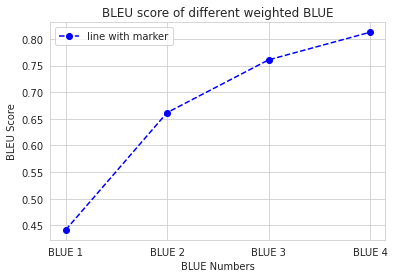

In [150]:
x = ['BLUE 1', 'BLUE 2', 'BLUE 3', 'BLUE 4']
y = np.array(total_blue)

# plt.figure(figsize=(10,6))
plt.title("BLEU score of different weighted BLUE")
plt.xlabel("BLUE Numbers")
plt.ylabel("BLEU Score")
plt.plot(x, y, linestyle='--', marker='o', color='b', label='line with marker')
plt.legend()
plt.show()

In [ ]:
!unzip /content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/ben-eng.zip

Archive:  /content/drive/MyDrive/NeuralMachineTranslation/models/NewModels/ben-eng.zip
  inflating: ben-eng.h5              


In [151]:
transformer=tf.keras.models.load_model("/content/drive/MyDrive/NMT_6TH_SEM/beg-eng.h5",custom_objects={'PositionalEmbedding': PositionalEmbedding, 'TransformerEncoder': TransformerEncoder, 'TransformerDecoder': TransformerDecoder})

In [152]:
import jiwer
test_eng_texts = [pair[0] for pair in test_pairs]
test_ben_texts = [pair[1] for pair in test_pairs]
werlist=[]
for i in range(100):
    input_sentence = test_ben_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("bengali: ",test_ben_texts[i]) 
    print("english : ",test_eng_texts[i])
    print("predicted: ",translated)
    werscore = jiwer.wer(test_eng_texts[i], translated)
    print("wer:", werscore)
    werlist.append(werscore)    
    print("____________________________________________________________________________") 

1
bengali:  আমাদের অবিলম্বে সাহায্যের প্রয়োজন।
english :  [start] We need help immediately. [end]
predicted:  [start] i want to drive [end]
wer: 0.6666666666666666
____________________________________________________________________________
2
bengali:  ওটা শুধু রক্ত।
english :  [start] It's only blood. [end]
predicted:  [start] thats just arrived [end]
wer: 0.6
____________________________________________________________________________
3
bengali:  এ তো খালি রক্ত।
english :  [start] It's just blood. [end]
predicted:  [start] he was elected in 2013 [end]
wer: 1.0
____________________________________________________________________________
4
bengali:  গাস না।
english :  [start] Don't sing. [end]
predicted:  [start] dont see [end]
wer: 0.5
____________________________________________________________________________
5
bengali:  আমি বাইরে থাকবো।
english :  [start] I'll be outside. [end]
predicted:  [start] ill come outside [end]
wer: 0.6
____________________________________________________

In [153]:
werlist

[0.6666666666666666,
 0.6,
 1.0,
 0.5,
 0.6,
 0.75,
 0.7142857142857143,
 0.6666666666666666,
 0.5,
 0.6,
 0.5,
 0.6666666666666666,
 0.6,
 0.4,
 0.375,
 0.5,
 0.5,
 0.75,
 0.6,
 0.4,
 0.3333333333333333,
 0.8,
 0.6666666666666666,
 0.8,
 0.4,
 0.625,
 0.75,
 0.375,
 0.4,
 0.75,
 0.6666666666666666,
 0.625,
 0.3333333333333333,
 0.7142857142857143,
 0.625,
 0.8333333333333334,
 0.4,
 0.8,
 1.25,
 0.7142857142857143,
 0.75,
 0.5,
 0.2857142857142857,
 0.6666666666666666,
 0.4,
 0.4,
 0.2222222222222222,
 0.4,
 0.6,
 0.5,
 1.0,
 0.3333333333333333,
 0.5,
 0.8571428571428571,
 0.5,
 0.75,
 0.5,
 0.5,
 0.8181818181818182,
 0.6,
 0.3333333333333333,
 0.625,
 0.5,
 0.5,
 0.625,
 0.6666666666666666,
 0.42857142857142855,
 0.3333333333333333,
 0.75,
 0.4,
 0.5,
 0.6666666666666666,
 0.5,
 0.5,
 0.2857142857142857,
 0.75,
 0.6,
 0.5714285714285714,
 0.5,
 0.6,
 0.75,
 0.5714285714285714,
 0.6666666666666666,
 0.5,
 0.25,
 1.0,
 0.6,
 0.6666666666666666,
 0.5714285714285714,
 0.3333333333333333,

In [154]:
print(sum(werlist)/len(werlist))

0.579570707070707


In [155]:
test_eng_texts = [pair[0] for pair in test_pairs]
test_ben_texts = [pair[1] for pair in test_pairs]
metlist=[]
for i in range(100):
    input_sentence = test_ben_texts[i]
    translated = decode_sequence(input_sentence)
    print(i+1)
    print("bengali: ",test_ben_texts[i]) 
    print("english : ",test_eng_texts[i])
    print("predicted: ",translated)
    metscore = single_meteor_score(word_tokenize(test_eng_texts[i]), word_tokenize(translated))
    print("meteor score:", metscore)
    metlist.append(metscore)    
    print("____________________________________________________________________________") 

1
bengali:  আমাদের অবিলম্বে সাহায্যের প্রয়োজন।
english :  [start] We need help immediately. [end]
predicted:  [start] i want to drive [end]
meteor score: 0.616925669350309
____________________________________________________________________________
2
bengali:  ওটা শুধু রক্ত।
english :  [start] It's only blood. [end]
predicted:  [start] thats just arrived [end]
meteor score: 0.5452674897119341
____________________________________________________________________________
3
bengali:  এ তো খালি রক্ত।
english :  [start] It's just blood. [end]
predicted:  [start] he was elected in 2013 [end]
meteor score: 0.5353535353535354
____________________________________________________________________________
4
bengali:  গাস না।
english :  [start] Don't sing. [end]
predicted:  [start] dont see [end]
meteor score: 0.600907029478458
____________________________________________________________________________
5
bengali:  আমি বাইরে থাকবো।
english :  [start] I'll be outside. [end]
predicted:  [start] ill c

In [156]:
metlist

[0.616925669350309,
 0.5452674897119341,
 0.5353535353535354,
 0.600907029478458,
 0.6226379440665155,
 0.654320987654321,
 0.6038032945736435,
 0.6600900423728814,
 0.8289915966386556,
 0.5503634475597092,
 0.7948022959183674,
 0.8030303030303031,
 0.6988249845392702,
 0.7212094907407407,
 0.8126721763085399,
 0.9054545454545455,
 0.600907029478458,
 0.8819444444444444,
 0.6792413935271077,
 0.7212094907407407,
 0.9137614678899082,
 0.4545454545454546,
 0.7080965909090909,
 0.54461634630411,
 0.6792413935271077,
 0.6474759883850792,
 0.6038032945736435,
 0.8440643218655903,
 0.78677398989899,
 0.7471655328798186,
 0.5402650356778795,
 0.5644248188405797,
 0.8211575489862951,
 0.5747427175998604,
 0.5336896663427275,
 0.565083176127594,
 0.78677398989899,
 0.45435741864313295,
 0.7519964507542148,
 0.8220833333333335,
 0.7687074829931974,
 0.6600900423728814,
 0.8369747899159665,
 0.6880733944954129,
 0.9041027559546079,
 0.78677398989899,
 0.8044763513513514,
 0.9041027559546079,
 0.6

In [157]:
print(sum(metlist)/len(metlist))

0.7059023343568708
